In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

### Часть 0. Подготовка

Скачайте обучающую выборку из [этого](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) соревнования и загрузите ее:

In [2]:
samp_sub_path = 'nyc-taxi-trip-duration/sample_submission.csv'
test_path = 'nyc-taxi-trip-duration/test.csv'
train_path = 'nyc-taxi-trip-duration/train.csv'

df = pd.read_csv(train_path, parse_dates=['pickup_datetime'])

In [3]:
df.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


#### Data fields
id - a unique identifier for each trip\
vendor_id - a code indicating the provider associated with the trip record\
pickup_datetime - date and time when the meter was engaged\
dropoff_datetime - date and time when the meter was disengaged\
passenger_count - the number of passengers in the vehicle (driver entered value)\
pickup_longitude - the longitude where the meter was engaged\
pickup_latitude - the latitude where the meter was engaged\
dropoff_longitude - the longitude where the meter was disengaged\
dropoff_latitude - the latitude where the meter was disengaged\
store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip\
**trip_duration** - duration of the trip in seconds

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [5]:
# этой колонки нет в тестовой выборке
df.drop(columns='dropoff_datetime', inplace=True)

Изучаем признак 'trip_duration'

In [6]:
# раскомментировать перед загрузкой
# sns.displot(df['trip_duration'], bins=5, kde=True)

Логарифмируем признак 'trip_duration'

In [7]:
# раскомментировать перед загрузкой
df['log_trip_duration'] = np.log1p(df['trip_duration'])
# sns.displot(df['log_trip_duration'], bins=11, kde=True)

Удаляем первоначальный таргет:

In [8]:
df.drop(columns='trip_duration', inplace=True)

Проверяем значение RMSLE при константном предсказании:

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
df['const'] = df['log_trip_duration'].mean()

rmsle = mean_squared_error(df['const'], df['log_trip_duration'], squared=False)

df.drop(columns='const', inplace=True)

rmsle

0.7957592365411509

Text(0.5, 0.98, 'Количество поездок за день')

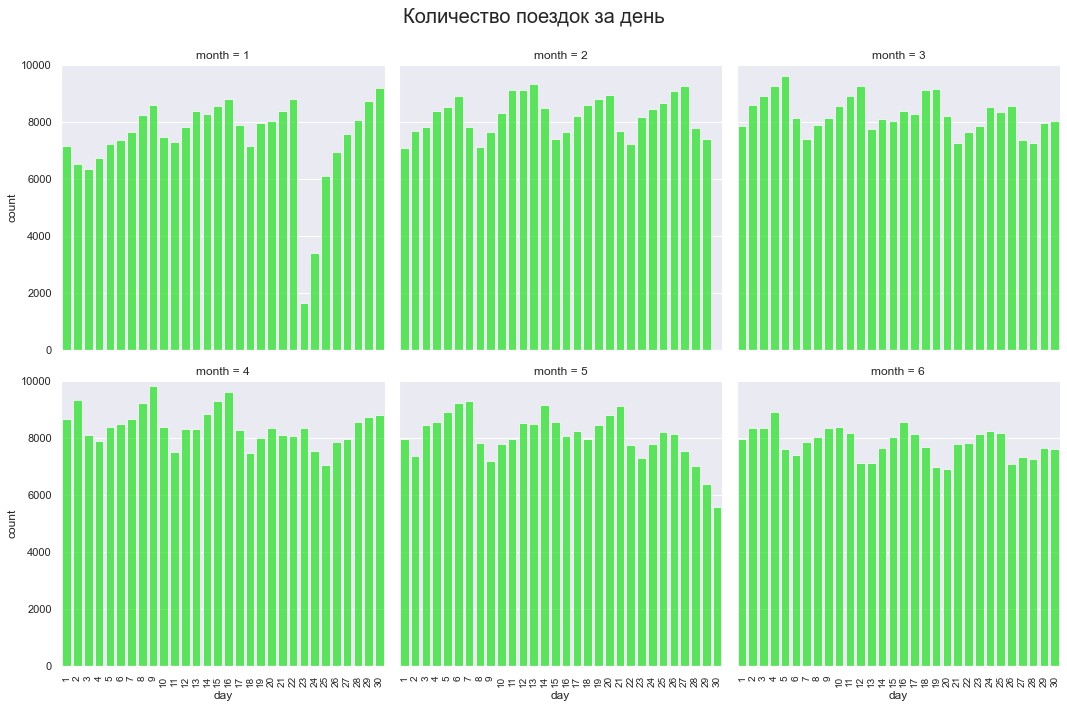

In [11]:

df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day

g = sns.FacetGrid(df, col='month', col_wrap=3, height=5, ylim=(0,10000))
g.map(sns.countplot, 'day', color='lime', alpha=0.7,
      order=[i for i in range(1,31)])
g.set_xticklabels(fontsize=10, rotation=90)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Количество поездок за день', fontsize=20)

#df.drop(columns=['month','day'], inplace=True)

На графиках видны несколько дней, в которых количество поездок было значительно ниже, чем обычно: 
* 23-24 января 2016 (в эти дни в Нью-Йорке была аномальная метель)
* 30 мая (день поминовения в США)

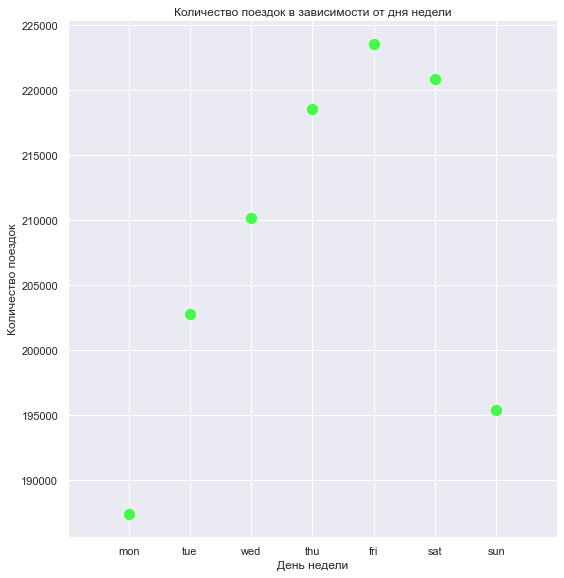

In [12]:
df['day_of_week'] = df['pickup_datetime'].dt.day_of_week
ax = sns.relplot(x=df['day_of_week'].value_counts().index,
                 y=df['day_of_week'].value_counts().values,
                 s=150, color='lime', alpha=0.7, height=8)
ax.set(title='Количество поездок в зависимости от дня недели',
       xlabel='День недели',
       ylabel='Количество поездок')
ax.set_xticklabels(['','mon','tue','wed','thu','fri','sat','sun',''])

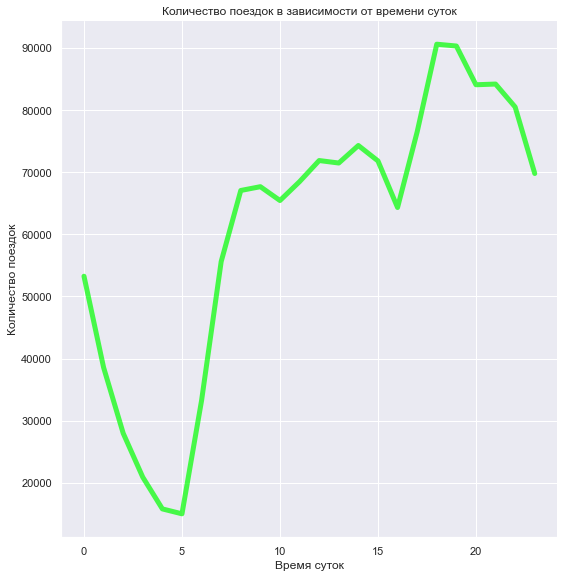

In [13]:
df['hour'] = df['pickup_datetime'].dt.hour
ax = sns.relplot(x=df['hour'].value_counts().index,
                 y=df['hour'].value_counts().values,
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5)#s=150, 
ax.set(title='Количество поездок в зависимости от времени суток',
       xlabel='Время суток',
       ylabel='Количество поездок')

In [14]:
gb_month_hour = pd.DataFrame(df.groupby(by=['month','hour'])['id'].count())

gb_month_hour.reset_index(level=['month','hour'], inplace=True)

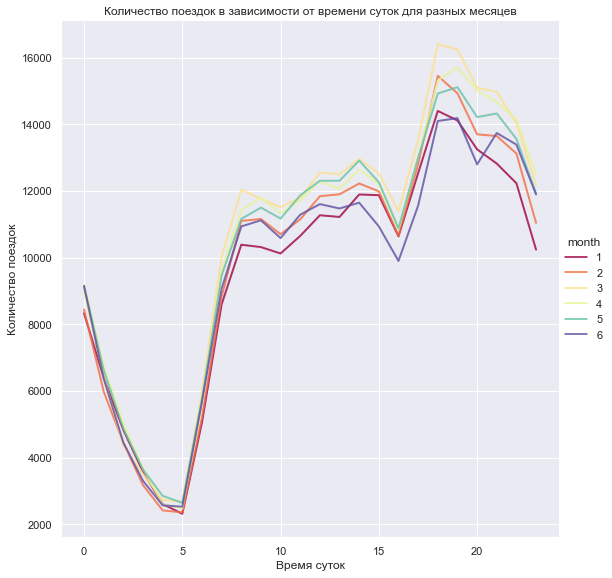

In [15]:
ax = sns.relplot(data=gb_month_hour, x='hour', y='id',
                 alpha=0.8, kind='line', palette='Spectral',
                 height=8, linewidth=2, hue='month')
ax.set(title='Количество поездок в зависимости от времени суток для разных месяцев',
       xlabel='Время суток',
       ylabel='Количество поездок')

В разные месяцы зависимость количества поездок от времени суток значительно не менялась

In [16]:
gb_dow_hour = pd.DataFrame(df.groupby(by=['day_of_week','hour'])['id'].count())

gb_dow_hour.reset_index(level=['day_of_week','hour'], inplace=True)

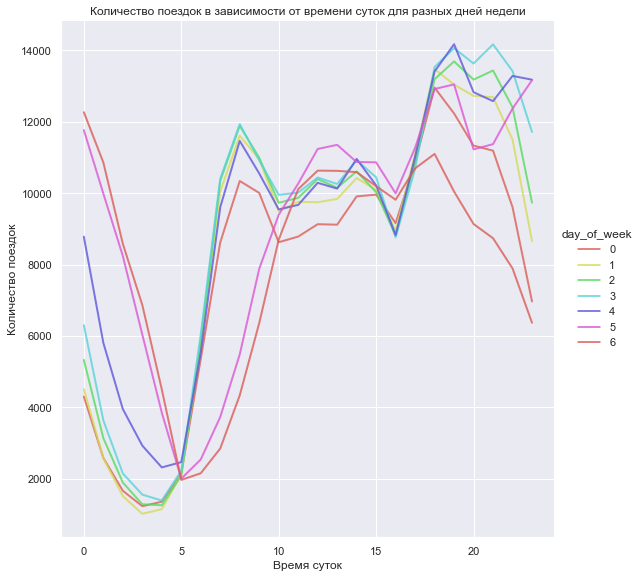

In [17]:
ax = sns.relplot(data=gb_dow_hour, x='hour', y='id',
                 alpha=0.8, kind='line', palette='hls',
                 height=8, linewidth=2, hue='day_of_week')
ax.set(title='Количество поездок в зависимости от времени суток для разных дней недели',
       xlabel='Время суток',
       ylabel='Количество поездок')

В субботу и воскресенье зависимость количества поездок от времени суток отличается от зависимости в будние дни:
* В период с 00 до 05 часов в выходные дни поездок больше, чем в будние дни (вероятнее всего, многие в это время возвращаются из баров, ресторанов, от друзей и т.д.)
* В период с 20 до 23 в пятницу и субботу также заметно увеличение количества поездок (можно объяснить теми же самыми причинами)
* В будние дни есть два периода с высокой активностью: 7 - 9 и 18 - 21, которых нет в выходные (люди едут на работу и возвращаюся с нее в это время)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(
#     df.drop(columns='log_trip_duration'), df['log_trip_duration'],
#     test_size=0.3, random_state=0)

In [20]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

In [21]:
gb_dow_target = pd.DataFrame(df_train.groupby(by=['day_of_week'])['log_trip_duration'].mean())
gb_dow_target.reset_index(level=['day_of_week'], inplace=True)

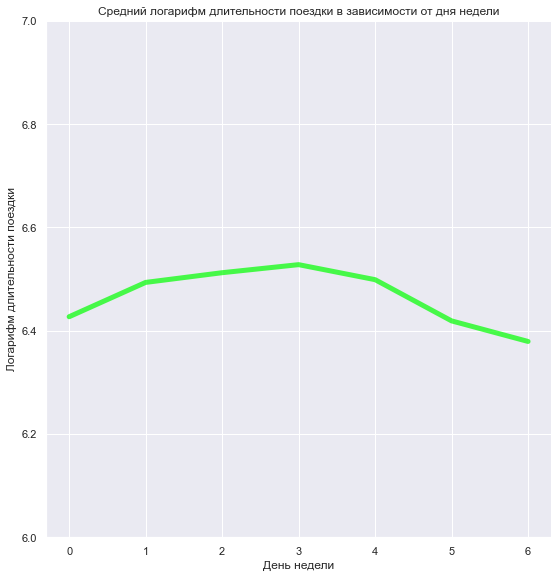

In [22]:
ax = sns.relplot(data=gb_dow_target, x='day_of_week',
                 y='log_trip_duration',
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5)#s=150, 

ax.set(title='Средний логарифм длительности поездки в зависимости от дня недели',
       xlabel='День недели',
       ylabel='Логарифм длительности поездки', ylim=(6,7))

In [23]:
gb_hour_target = pd.DataFrame(df_train.groupby(by=['hour'])['log_trip_duration'].mean())
gb_hour_target.reset_index(level=['hour'], inplace=True)

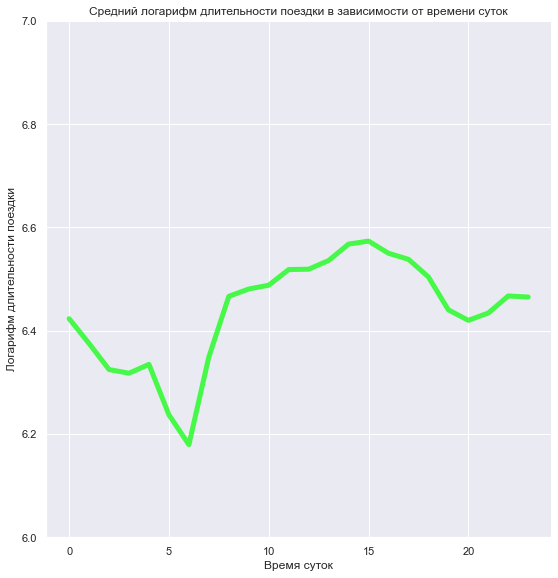

In [24]:
ax = sns.relplot(data=gb_hour_target, x='hour',
                 y='log_trip_duration',
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5)#s=150, 

ax.set(title='Средний логарифм длительности поездки в зависимости от времени суток',
       xlabel='Время суток',
       ylabel='Логарифм длительности поездки', ylim=(6, 7))

In [26]:
gb_md = pd.DataFrame(df_train.groupby(by=['month','day'])['log_trip_duration'].mean())

gb_md.reset_index(level=['month','day'], inplace=True)

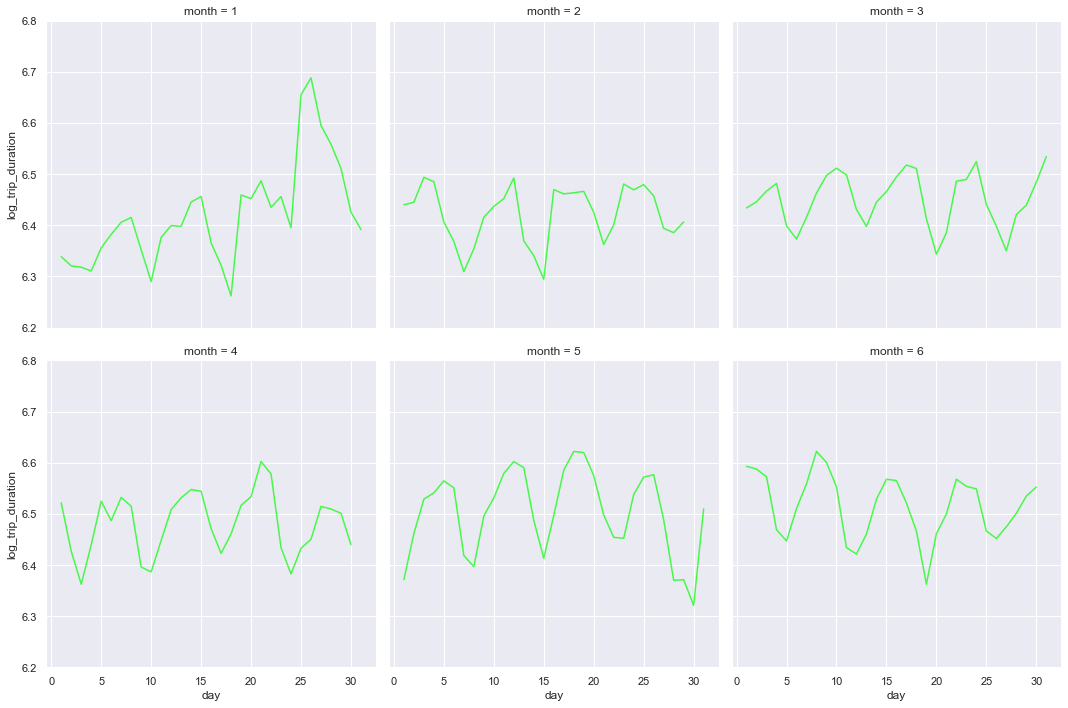

In [28]:
g = sns.FacetGrid(gb_md, col='month', col_wrap=3, height=5, ylim=(6.2,6.8))
g.map(sns.lineplot, 'day','log_trip_duration', color='lime', alpha=0.7)

In [29]:
df['is_anomaly_1'] = ((df['day'] == 23) & (df['month'] == 1)) |\
    ((df['day'] == 24) & (df['month'] == 1)) |\
    ((df['day'] == 25) & (df['month'] == 1))
df['is_anomaly_2'] = ((df['day'] == 30) & (df['month'] == 5))

In [30]:
df['day_of_year'] = df['pickup_datetime'].dt.day_of_year

In [31]:
df[:2]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,month,day,day_of_week,hour,is_anomaly_1,is_anomaly_2,day_of_year
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,3,14,0,17,False,False,74
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,6,12,6,0,False,False,164


In [ ]:
df.drop(columns=['id','vendor_id','pickup_datetime'])